In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
path = './gdrive/MyDrive/colab/'

In [ ]:
df = pd.read_csv(path + 'train.csv')
df.head()

,UNC_YEAR,HSCD,COUNTRYCD,COUNTRYNM,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,2017,190590,12,Algeria,4.605299e+10,1.948099e+10,30.0,3878.238437,1.701630e+11,1.599950e+11,41389198,110.973017,46.109810,9954.009766,3416326.0,7657
1,2017,190590,36,Australia,2.284420e+11,1.948099e+10,0.0,12203.155980,1.329190e+12,1.208850e+12,24601860,1.304758,80.223690,8329.652344,438747025.0,5294788
2,2017,190590,40,Austria,1.664750e+11,1.948099e+10,0.0,4403.247293,4.172380e+11,3.955690e+11,8797566,NaN,78.856460,8289.029297,453206357.0,335818
3,2017,190590,56,Belgium,4.064120e+11,1.948099e+10,0.0,3980.375563,5.026980e+11,4.757400e+11,11375158,NaN,72.409200,8722.114258,706524512.0,173709
4,2017,190590,76,Brazil,1.507490e+11,1.948099e+10,18.0,9644.206941,2.062830e+12,1.795700e+12,207833831,3.191389,55.382403,18364.505860,31329648.0,122850


In [ ]:
# columns = ["UNC_YEAR","HSCD","COUNTRYCD","COUNTRYNM","TRADE_COUNTRYCD","TRADE_HSCD","TARIFF_AVG","SNDIST","NY_GDP_MKTP_CD","NY_GDP_MKTP_CD_1Y","SP_POP_TOTL","IC_BUS_EASE_DFRN_DB","KMDIST","TRADE_HSCD_COUNTRYCD","KR_TRADE_HSCD_COUNTRYCD"] # 12526300.9116
columns = ["HSCD","COUNTRYCD","TRADE_COUNTRYCD","TRADE_HSCD","TARIFF_AVG","NY_GDP_MKTP_CD","NY_GDP_MKTP_CD_1Y","SP_POP_TOTL","IC_BUS_EASE_DFRN_DB","TRADE_HSCD_COUNTRYCD","KR_TRADE_HSCD_COUNTRYCD"]
df = df[columns].copy()
print(df['TARIFF_AVG'].mean())
df['TARIFF_AVG'] = df['TARIFF_AVG'].fillna(df['TARIFF_AVG'].mean())

df = df.dropna(axis=0)
df.head()

,HSCD,COUNTRYCD,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,IC_BUS_EASE_DFRN_DB,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,190590,12,4.605299e+10,1.948099e+10,30.0,1.701630e+11,1.599950e+11,41389198,46.109810,3416326.0,7657
1,190590,36,2.284420e+11,1.948099e+10,0.0,1.329190e+12,1.208850e+12,24601860,80.223690,438747025.0,5294788
2,190590,40,1.664750e+11,1.948099e+10,0.0,4.172380e+11,3.955690e+11,8797566,78.856460,453206357.0,335818
3,190590,56,4.064120e+11,1.948099e+10,0.0,5.026980e+11,4.757400e+11,11375158,72.409200,706524512.0,173709
4,190590,76,1.507490e+11,1.948099e+10,18.0,2.062830e+12,1.795700e+12,207833831,55.382403,31329648.0,122850


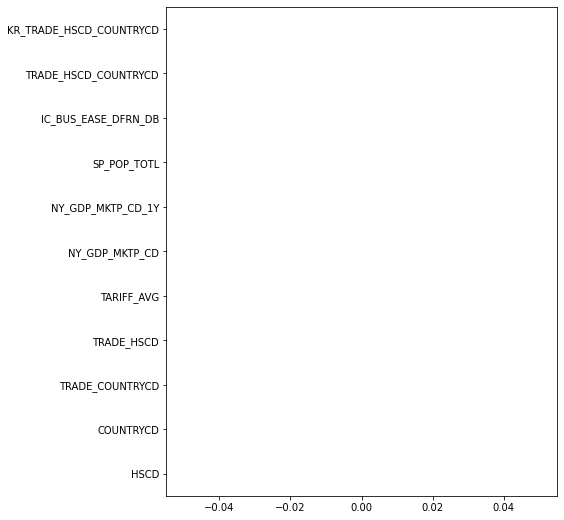

In [ ]:
df.isnull().mean().plot.barh(figsize=(7,9))

In [ ]:
df.shape

(21168, 11)

In [ ]:
df["percent"] = df["KR_TRADE_HSCD_COUNTRYCD"] / df["TRADE_HSCD_COUNTRYCD"] * 100
df["percent"]

0        0.224130
1        1.206797
2        0.074098
3        0.024586
4        0.392121
           ...   
21183    1.357677
21184    0.428503
21185    7.172731
21187    1.739317
21188    2.783575
Name: percent, Length: 21168, dtype: float64

In [ ]:
df = df.drop('KR_TRADE_HSCD_COUNTRYCD', axis=1).copy()
df = df.drop('TRADE_HSCD_COUNTRYCD', axis=1).copy()

In [ ]:
df.shape

(21168, 10)

In [ ]:
print(df.shape)
tr = int(df.shape[0]*6/10) # Train
te = int((df.shape[0] - tr)/2) # Test (actually Train)
va = df.shape[0] - tr - te # Validation (actually Test)
print(tr,te, va)

(21168, 10)
12700 4234 4234


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)
device = torch.device("cuda")

In [ ]:
import torch

x_train = torch.FloatTensor(df.iloc[:tr+te,:-1].values).to(device)
y_train = torch.FloatTensor(df.iloc[:tr+te,-1].values).to(device)
x_test = torch.FloatTensor(df.iloc[tr+te:,:-1].values).to(device)
y_test = torch.FloatTensor(df.iloc[tr+te:,-1].values).to(device)

max(y_train)

tensor(3357.3669, device='cuda:0')

In [ ]:
print(x_train.shape)
print(y_train.shape)

torch.Size([16934, 9])
torch.Size([16934])


In [ ]:
class Model(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(Model, self).__init__()
    self.bn = nn.BatchNorm1d(in_channel)
    self.layer1 = nn.Linear(in_channel, out_channel)
  def forward(self, x):
    x = x.to(device)
    return self.layer1(self.bn(x))

class DeepModel(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(DeepModel, self).__init__()

    self.basic = nn.BatchNorm1d(in_channel)
    self.layer1 = nn.Linear(in_channel, 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.layer2 = nn.Linear(256, 64)
    self.bn2 = nn.BatchNorm1d(64)
    self.head = nn.Linear(64, out_channel)

  def forward(self, x):
    x = x.to(device)
    x = self.basic(x)
    x = F.relu(self.bn1(self.layer1(x)))
    x = F.relu(self.bn2(self.layer2(x)))
    
    return self.head(x)

# model = nn.Linear(9,1).to(device)
model = TestModel(9, 1).to(device)
deepmodel = DeepModel(9, 1).to(device)
model.eval()
deepmodel.eval()

In [ ]:
optimizer = torch.optim.SGD(deepmodel.parameters(), lr=1e-2)

In [ ]:
n_epochs = 20000

for epoch in range(n_epochs):
  pred = deepmodel(x_train).to(device)
  cost = F.mse_loss(pred, y_train)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 10000 == 0:
    print("Ep {} cost : {}".format(epoch, cost.item()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Using a target size (torch.Size([16934])) that is different to the input size (torch.Size([16934, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  """


Ep 0 cost : 2058.516845703125
Ep 10000 cost : 2058.502197265625


In [ ]:
pred_y = deepmodel(x_train[:10])

In [ ]:
x_train[:10]

tensor([[1.9059e+05, 1.2000e+01, 4.6053e+10, 1.9481e+10, 3.0000e+01, 1.7016e+11,
         1.6000e+11, 4.1389e+07, 4.6110e+01],
        [1.9059e+05, 3.6000e+01, 2.2844e+11, 1.9481e+10, 0.0000e+00, 1.3292e+12,
         1.2089e+12, 2.4602e+07, 8.0224e+01],
        [1.9059e+05, 4.0000e+01, 1.6648e+11, 1.9481e+10, 0.0000e+00, 4.1724e+11,
         3.9557e+11, 8.7976e+06, 7.8856e+01],
        [1.9059e+05, 5.6000e+01, 4.0641e+11, 1.9481e+10, 0.0000e+00, 5.0270e+11,
         4.7574e+11, 1.1375e+07, 7.2409e+01],
        [1.9059e+05, 7.6000e+01, 1.5075e+11, 1.9481e+10, 1.8000e+01, 2.0628e+12,
         1.7957e+12, 2.0783e+08, 5.5382e+01],
        [1.9059e+05, 1.0400e+02, 1.9253e+10, 1.9481e+10, 5.0000e+00, 6.8946e+10,
         6.7184e+10, 5.3383e+07, 4.2671e+01],
        [1.9059e+05, 1.2400e+02, 4.3240e+11, 1.9481e+10, 0.0000e+00, 1.6499e+12,
         1.5282e+12, 3.6543e+07, 7.9541e+01],
        [1.9059e+05, 1.4400e+02, 2.1316e+10, 1.9481e+10, 3.0000e+01, 8.7428e+10,
         8.2401e+10, 2.1444e+0

In [ ]:
pred_y

tensor([[5.8165],
        [5.2681],
        [4.9635],
        [5.7995],
        [6.1344],
        [6.0141],
        [5.7864],
        [5.6373],
        [6.0389],
        [4.2520]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
torch.mean((pred_y - y_train[:10]) ** 2)

tensor(20.1330, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
df.head()

,HSCD,COUNTRYCD,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,IC_BUS_EASE_DFRN_DB,percent
0,190590,12,4.605299e+10,1.948099e+10,30.0,1.701630e+11,1.599950e+11,41389198,46.109810,0.224130
1,190590,36,2.284420e+11,1.948099e+10,0.0,1.329190e+12,1.208850e+12,24601860,80.223690,1.206797
2,190590,40,1.664750e+11,1.948099e+10,0.0,4.172380e+11,3.955690e+11,8797566,78.856460,0.074098
3,190590,56,4.064120e+11,1.948099e+10,0.0,5.026980e+11,4.757400e+11,11375158,72.409200,0.024586
4,190590,76,1.507490e+11,1.948099e+10,18.0,2.062830e+12,1.795700e+12,207833831,55.382403,0.392121


In [ ]:
model(new_var)

tensor([nan], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
# W = torch.zeros((9,1), requires_grad=True)
# b = torch.zeros(1, requires_grad=True)
# optimizer = optim.SGD([W,b], lr=1e-5)

# epochs = 1000
# for epoch in range(epochs):
#   hypothesis = (x_train.matmul(W) + b)
#   cost = torch.mean((hypothesis - y_train) ** 2)

#   optimizer.zero_grad()
#   cost.backward()
#   optimizer.step()
#   if epoch % 50 == 0:
#     print("Ep {} cost : {}".format(epoch, cost.item()))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
batch_size = 16
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 3

units = 16
output_size = 3358  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim), activation='relu')
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [ ]:
df_perc = df["percent"].copy()
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/x.std(), axis=0)
df_back = df.copy()
df = mean_norm(df)
df["percent"] = df_perc
df.head()

,HSCD,COUNTRYCD,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,IC_BUS_EASE_DFRN_DB,percent
0,-2.715736,-1.723865,-0.639063,0.110114,3.081394,-0.429544,-0.426263,-0.285299,-2.331051,0.224130
1,-2.715736,-1.629466,-0.246060,0.110114,-0.376954,-0.092166,-0.104394,-0.344291,0.899075,1.206797
2,-2.715736,-1.613733,-0.379583,0.110114,-0.376954,-0.357624,-0.353971,-0.399828,0.769616,0.074098
3,-2.715736,-1.550801,0.137421,0.110114,-0.376954,-0.332747,-0.329368,-0.390770,0.159147,0.024586
4,-2.715736,-1.472136,-0.413469,0.110114,1.698055,0.121388,0.075697,0.299598,-1.453061,0.392121


In [ ]:
import torch

x_train = np.array(df.iloc[:tr+te,:-1].values)
y_train = np.array(df.iloc[:tr+te,-1].values)
x_test = np.array(df.iloc[tr+te:,:-1].values)
y_test = np.array(df.iloc[tr+te:,-1].values)

max(y_train)

3357.3670103606646

In [ ]:
## Linear Test Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
torch.manual_seed(1)

In [ ]:
x_train.shape

(16934, 9)

In [ ]:
x_train[0]

array([-2.71573567, -1.72386485, -0.63906278,  0.1101143 ,  3.08139384,
       -0.42954444, -0.42626326, -0.28529889, -2.33105123])

In [ ]:
model = nn.Linear(x_train.shape[1], 1)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
epochs = 20000

In [ ]:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

y_train = y_train.reshape(-1,1)

for epoch in range(epochs+1):
    pred = model(x_train)
    
    cost = F.mse_loss(pred, y_train)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print('Epoch : {}/{}, Cost = {}'.format(epoch, epochs, cost.item()))
        

Epoch : 0/20000, Cost = 2088.326904296875
Epoch : 100/20000, Cost = 2088.159423828125
Epoch : 200/20000, Cost = 2087.991943359375
Epoch : 300/20000, Cost = 2087.825927734375
Epoch : 400/20000, Cost = 2087.66064453125
Epoch : 500/20000, Cost = 2087.49609375
Epoch : 600/20000, Cost = 2087.33203125
Epoch : 700/20000, Cost = 2087.1689453125
Epoch : 800/20000, Cost = 2087.006591796875
Epoch : 900/20000, Cost = 2086.844970703125
Epoch : 1000/20000, Cost = 2086.68408203125
Epoch : 1100/20000, Cost = 2086.52392578125
Epoch : 1200/20000, Cost = 2086.3642578125
Epoch : 1300/20000, Cost = 2086.2060546875
Epoch : 1400/20000, Cost = 2086.0478515625
Epoch : 1500/20000, Cost = 2085.890625
Epoch : 1600/20000, Cost = 2085.734130859375
Epoch : 1700/20000, Cost = 2085.57861328125
Epoch : 1800/20000, Cost = 2085.42333984375
Epoch : 1900/20000, Cost = 2085.269287109375
Epoch : 2000/20000, Cost = 2085.115966796875
Epoch : 2100/20000, Cost = 2084.962890625
Epoch : 2200/20000, Cost = 2084.810791015625
Epoch :

In [ ]:
x_train.shape

torch.Size([16934, 9])

In [ ]:
y_train.shape

torch.Size([16934, 1])

In [ ]:
new_var = torch.FloatTensor(df.iloc[2][:-1])
new_var = new_var.reshape(1,-1)
new_var

tensor([[-2.7157, -1.6137, -0.3796,  0.1101, -0.3770, -0.3576, -0.3540, -0.3998,
          0.7696]])

In [ ]:
pred_y = model(new_var)

In [ ]:
pred_y

tensor([[1.1609]], grad_fn=<AddmmBackward>)

In [ ]:
df.iloc[2][:-1]

HSCD                  -2.715736
COUNTRYCD             -1.613733
TRADE_COUNTRYCD       -0.379583
TRADE_HSCD             0.110114
TARIFF_AVG            -0.376954
NY_GDP_MKTP_CD        -0.357624
NY_GDP_MKTP_CD_1Y     -0.353971
SP_POP_TOTL           -0.399828
IC_BUS_EASE_DFRN_DB    0.769616
Name: 2, dtype: float64

In [ ]:
torch.FloatTensor(x_test[0]).reshape(1,-1)

tensor([[ 0.5468, -1.1732, -0.5977, -0.0511, -0.3770, -0.3984, -0.3985, -0.3658,
          0.0808]])

In [ ]:
import math

err_sum = 0.0
for i in range(x_test.shape[0]):
    new_var = torch.FloatTensor(x_test[i]).reshape(1,-1)
    pred_y = model(new_var)
    err_val = y_test[i] - pred_y
    err_sum += np.sqrt(math.pow(err_val, 2))


In [ ]:
err_sum / x_test.shape[0]

4.0840497331928685

In [ ]:
test_df = pd.read_csv(path + 'test.csv')
test_df.head()

,UNC_YEAR,HSCD,COUNTRYCD,COUNTRYNM,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,2018,190590,12,Algeria,4.219612e+10,2.223464e+10,27.0,3735.047389,1.754060e+11,1.701630e+11,42228429.0,100.691433,46.22686,9954.009766,6788998.0,NaN
1,2018,190590,36,Australia,2.404230e+11,2.223464e+10,1.2,11947.511360,1.432880e+12,1.329190e+12,24982688.0,1.035843,80.76007,8329.652344,482560567.0,NaN
2,2018,190590,40,Austria,1.869650e+11,2.223464e+10,2.8,4005.020029,4.550950e+11,4.172380e+11,8840521.0,NaN,78.70694,8289.029297,499925873.0,NaN
3,2018,190590,56,Belgium,4.614450e+11,2.223464e+10,2.8,4501.782826,5.437340e+11,5.026980e+11,11427054.0,NaN,72.18146,8722.114258,769101370.0,NaN
4,2018,190590,76,Brazil,1.852900e+11,2.223464e+10,17.1,10015.769070,1.885480e+12,2.062830e+12,209469333.0,2.156089,55.80145,18364.505860,40817292.0,NaN


In [ ]:
columns = ["HSCD","COUNTRYCD","TRADE_COUNTRYCD","TRADE_HSCD","TARIFF_AVG","SNDIST","NY_GDP_MKTP_CD","NY_GDP_MKTP_CD_1Y","SP_POP_TOTL","IC_BUS_EASE_DFRN_DB","KMDIST","TRADE_HSCD_COUNTRYCD","KR_TRADE_HSCD_COUNTRYCD"]
test_df = test_df[columns].copy()

test_df['SNDIST'] = test_df['SNDIST'].fillna(test_df['SNDIST'].mean())
test_df['TARIFF_AVG'] = test_df['TARIFF_AVG'].fillna(test_df['TARIFF_AVG'].mean())


test_df = test_df.drop('SNDIST', axis=1).copy()
test_df = test_df.drop('KMDIST', axis=1).copy()


In [ ]:
test_df.head()

,HSCD,COUNTRYCD,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,IC_BUS_EASE_DFRN_DB,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,190590,12,4.219612e+10,2.223464e+10,27.0,1.754060e+11,1.701630e+11,42228429.0,46.22686,6788998.0,NaN
1,190590,36,2.404230e+11,2.223464e+10,1.2,1.432880e+12,1.329190e+12,24982688.0,80.76007,482560567.0,NaN
2,190590,40,1.869650e+11,2.223464e+10,2.8,4.550950e+11,4.172380e+11,8840521.0,78.70694,499925873.0,NaN
3,190590,56,4.614450e+11,2.223464e+10,2.8,5.437340e+11,5.026980e+11,11427054.0,72.18146,769101370.0,NaN
4,190590,76,1.852900e+11,2.223464e+10,17.1,1.885480e+12,2.062830e+12,209469333.0,55.80145,40817292.0,NaN


In [ ]:
test_df = mean_norm(test_df)
x_test = np.array(test_df.iloc[:,:-2].values)
x_test[0]

array([-2.71217613, -1.72467426, -0.65658563,  0.11474505,  2.72387212,
       -0.42743595, -0.42940035, -0.28357208, -2.43669591])

In [ ]:
result = pd.read_csv(path + 'test.csv')
pd.options.display.float_format = '{:.5f}'.format
res = []
for i in range(x_test.shape[0]):
    new_var = torch.FloatTensor(x_test[i]).reshape(1,-1)
    pred_y = model(new_var)
    result["KR_TRADE_HSCD_COUNTRYCD"][i] = (result["TRADE_HSCD_COUNTRYCD"][i] * (float(pred_y)/100))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
result.to_csv(path+"filename.csv", mode='w')

In [ ]:
df.head()

,HSCD,COUNTRYCD,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,IC_BUS_EASE_DFRN_DB,percent
0,-2.71574,-1.72386,-0.63906,0.11011,3.08139,-0.42954,-0.42626,-0.28530,-2.33105,0.22413
1,-2.71574,-1.62947,-0.24606,0.11011,-0.37695,-0.09217,-0.10439,-0.34429,0.89907,1.20680
2,-2.71574,-1.61373,-0.37958,0.11011,-0.37695,-0.35762,-0.35397,-0.39983,0.76962,0.07410
3,-2.71574,-1.55080,0.13742,0.11011,-0.37695,-0.33275,-0.32937,-0.39077,0.15915,0.02459
4,-2.71574,-1.47214,-0.41347,0.11011,1.69805,0.12139,0.07570,0.29960,-1.45306,0.39212
